In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- USER EDIT: set these two paths ---
CSV_PATH = "/sdf/data/rubin/user/mrakovci/Projects/Asteroid_detection_CNN/Notebooks/SNR_tests/test.csv"  # your injection catalog
REPO_ROOT = "/sdf/data/rubin/user/mrakovci/Projects/Asteroid_detection_CNN/"  # e.g. "/sdf/home/m/mrakovci/rubin-user/Projects/Asteroid_detection_CNN/ADCNN/data/dataset_creation"
# If you run the notebook from the repo already, leave REPO_ROOT=None.

# Add repo to sys.path so we can import your common.py
if REPO_ROOT is not None:
    rr = Path(REPO_ROOT).resolve()
    if str(rr) not in sys.path:
        sys.path.insert(0, str(rr))

sys.path.insert(0, "/sdf/data/rubin/user/mrakovci/Projects/Asteroid_detection_CNN/ADCNN/data/dataset_creation")
# Import your estimators from common.py (the functions you added)
from ADCNN.data.dataset_creation.simulate_inject import *

# LSST imports (must be in an environment where lsst_distrib is set up)
import lsst.daf.butler as dafButler
import lsst.geom as geom


In [2]:
import concurrent.futures
import pandas as pd
import numpy as np
from lsst.daf.butler import Butler

def worker_df(args):
    """
    Runs one_detector_injection for a single (visit,detector) and returns a pandas DataFrame.
    No H5, no CSV. Only catalog.
    """
    (
        dataId, repo, coll, dims, number, trail_length, magnitude, beta,
        source_type, global_seed, mag_mode, psf_template
    ) = args

    seed = (int(global_seed) * 1_000_003 + int(dataId["visit"]) * 1_003 + int(dataId["detector"])) & 0xFFFFFFFF

    res = one_detector_injection(
        number, trail_length, magnitude, beta,
        repo, coll, dims, source_type, dataId, seed,
        mag_mode=mag_mode, psf_template=psf_template,
        debug=False,
    )

    # res is either (False, dataId, err, tb) or (True, img, mask, real_labels, injection_catalog)
    if res[0] is False:
        _, bad_dataId, err, tb = res
        # Return empty df but keep error info for debugging if you want
        return ("err", bad_dataId, err, tb, None)

    _, img, mask, real_labels, catalog = res
    df = catalog.to_pandas()
    # keep provenance columns
    df["visit"] = int(dataId["visit"])
    df["detector"] = int(dataId["detector"])
    return ("ok", dataId, None, None, df)


def run_parallel_injection_df(
    repo, coll, where,
    number, trail_length, magnitude, beta,
    parallel=4, random_subset=0, train_test_split=0, seed=123, test_only=False,
    bad_visits_file=None, mag_mode="psf_mag", psf_template="image",
):
    """
    Like run_parallel_injection(), but returns one concatenated DataFrame and does not write H5/CSV.
    """
    butler = Butler(repo, collections=coll)

    refs = list(set(
        butler.registry.queryDatasets(
            "preliminary_visit_image",
            where=where,
            instrument="LSSTComCam",
            findFirst=True
        )
    ))
    refs = sorted(refs, key=lambda r: int(r.dataId["visit"]) * 1000 + int(r.dataId["detector"]))

    if bad_visits_file is not None:
        bad_df = pd.read_csv(bad_visits_file)
        bad_set = set(zip(bad_df["visit"].astype(int), bad_df["detector"].astype(int)))
        refs = [r for r in refs if (int(r.dataId["visit"]), int(r.dataId["detector"])) not in bad_set]

    if random_subset > 0:
        rng_subset = np.random.default_rng(seed)
        refs = list(rng_subset.choice(refs, random_subset, replace=False))

    # optional train/test split logic preserved (same as your code)
    rng_split = np.random.default_rng(seed + 1)
    test_index = rng_split.choice(
        np.arange(len(refs)),
        int((1 - train_test_split) * len(refs)),
        replace=False
    ) if 0 < train_test_split < 1 else np.array([], dtype=int)

    if test_only:
        refs = [refs[i] for i in test_index]
    else:
        # if not test_only and split requested, keep all refs (you can filter later if you want)
        pass

    dims = butler.get("preliminary_visit_image.dimensions", dataId=refs[0].dataId)

    tasks = []
    for ref in refs:
        tasks.append((
            ref.dataId, repo, coll, dims, number, trail_length, magnitude, beta,
            "preliminary_visit_image", seed, mag_mode, psf_template
        ))

    dfs = []
    errors = []

    if parallel > 1:
        with concurrent.futures.ProcessPoolExecutor(max_workers=parallel) as ex:
            futs = [ex.submit(worker_df, t) for t in tasks]
            completed = 0
            total = len(futs)

            for fut in concurrent.futures.as_completed(futs):
                completed += 1
                status, dataId, err, tb, df = fut.result()

                if status == "ok":
                    dfs.append(df)
                    print(f"[{completed}/{total}] ok visit={dataId['visit']} det={dataId['detector']}", flush=True)
                else:
                    errors.append((dataId, err, tb))
                    print(f"[{completed}/{total}] ERROR visit={dataId['visit']} det={dataId['detector']}", flush=True)
                    print(err, flush=True)
                    print(tb, flush=True)

    else:
        for i, t in enumerate(tasks, 1):
            status, dataId, err, tb, df = worker_df(t)
            if status == "ok":
                dfs.append(df)
                print(f"[{i}/{len(tasks)}] ok visit={dataId['visit']} det={dataId['detector']}", flush=True)
            else:
                errors.append((dataId, err, tb))
                print(f"[{i}/{len(tasks)}] ERROR visit={dataId['visit']} det={dataId['detector']}", flush=True)
                print(err, flush=True)
                print(tb, flush=True)

    out = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
    return out, errors


In [22]:
df_tk, errors = run_parallel_injection_df(
    repo="/repo/main",
    coll="LSSTComCam/runs/DRP/DP1/w_2025_17/DM-50530",
    where="instrument='LSSTComCam' AND skymap='lsst_cells_v1' AND day_obs>=20241101 AND day_obs<=20241127 AND exposure.observation_type='science' AND band in ('u','g','r','i','z','y') AND (exposure not in (2024110600163, 2024112400111, 2024110800318, 2024111200185, 2024111400039, 2024111500225, 2024111500226, 2024111500239, 2024111500240, 2024111500242, 2024111500288, 2024111500289, 2024111800077, 2024111800078, 2024112300230, 2024112400094, 2024112400225, 2024112600327))",   # <-- adjust
    bad_visits_file="/sdf/data/rubin/user/mrakovci/Projects/Asteroid_detection_CNN/ADCNN/data/dataset_creation/bad_visits.csv",
    number=1000,
    trail_length=[6, 60],
    magnitude=[5, 5],            # used as SNR bounds if mag_mode="snr"
    beta=[0, 180],
    parallel=4,
    random_subset=15,
    train_test_split=0,
    seed=123,
    mag_mode="snr",
    psf_template="kernel",
)

[1/15] ok visit=2024111200291 det=6
[2/15] ok visit=2024111500241 det=0
[3/15] ok visit=2024110800278 det=4
[4/15] ok visit=2024112700083 det=1
[5/15] ok visit=2024111600303 det=5
[6/15] ok visit=2024111700354 det=4
[7/15] ok visit=2024112300234 det=4
[8/15] ok visit=2024111900341 det=8
[9/15] ok visit=2024110800254 det=5
[10/15] ok visit=2024111200286 det=4
[11/15] ok visit=2024112400275 det=7
[12/15] ok visit=2024111900343 det=0
[13/15] ok visit=2024111700363 det=4
[14/15] ok visit=2024112600132 det=6
[15/15] ok visit=2024112600318 det=3


In [23]:
df_tk

,ra,dec,source_type,trail_length,mag,beta,visit,detector,integrated_mag,PSF_mag,...,physical_filter,x,y,SNR_estimation,m5_local,m5_detector,stack_detection,stack_mag,stack_mag_err,stack_snr
0,53.244256,-28.188618,Trail,22.955399,25.476344,85.703227,2024111200291,6,22.074132,23.164090,...,z,3164,2655,3.116201,22.408382,23.164090,False,NaN,NaN,NaN
1,53.160026,-28.273538,Trail,24.801832,25.479861,33.618360,2024111200291,6,21.993651,23.164090,...,z,1389,1674,3.230182,22.466057,23.164090,False,NaN,NaN,NaN
2,53.132975,-28.175063,Trail,36.192908,25.525664,87.984166,2024111200291,6,21.629105,23.164090,...,z,3027,880,3.177550,22.414069,23.164090,True,22.741011,0.197635,5.493648
3,53.200865,-28.349510,Trail,48.174797,25.554758,30.890472,2024111200291,6,21.347708,23.164090,...,z,192,2595,3.286980,22.439843,23.164090,False,NaN,NaN,NaN
4,53.087575,-28.183725,Trail,45.023878,25.563759,9.956504,2024111200291,6,21.430151,23.164090,...,z,2722,210,3.161631,22.394169,23.164090,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,94.997706,-24.802489,Trail,35.948393,27.430849,70.905638,2024112600318,3,23.541650,24.923516,...,g,3519,3282,3.777344,24.266869,24.923516,True,24.575988,0.204309,5.314186
14996,95.095960,-24.781312,Trail,19.099376,27.331722,79.715614,2024112600318,3,24.129174,24.923516,...,g,3702,1644,3.792565,24.276179,24.923516,False,NaN,NaN,NaN
14997,94.956683,-24.784412,Trail,33.584259,27.420936,163.914114,2024112600318,3,23.605597,24.923516,...,g,2988,3802,3.504416,24.266978,24.923516,False,NaN,NaN,NaN
14998,95.100116,-24.682371,Trail,26.883586,27.388062,128.343074,2024112600318,3,23.814344,24.923516,...,g,2052,979,3.578525,24.284556,24.923516,False,NaN,NaN,NaN


Text(0.5, 1.0, 'Fixed injected PSF magnitude to m5')

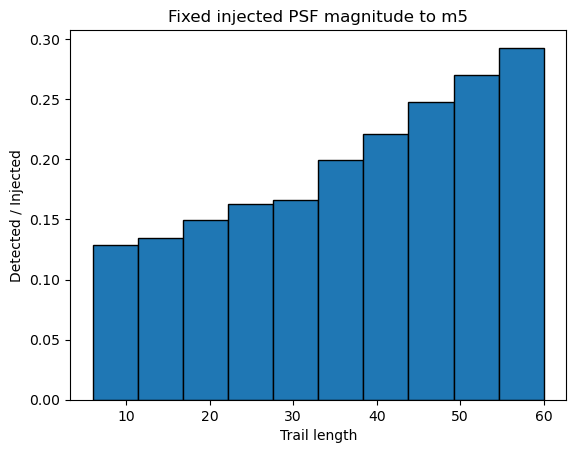

In [27]:
n=int((60-6)/5)+1
counts_total, bin_edges = np.histogram (df_tk["trail_length"], bins=np.linspace(6, 60, n))
counts_detected, bin_edges = np.histogram (df_tk["trail_length"][df_tk["stack_detection"]], bins=np.linspace(6, 60, n))
plt.bar(bin_edges[:-1], counts_detected/counts_total, width=np.diff(bin_edges), align='edge', edgecolor='black')
#plt.hlines(0.5, xmin=-1, xmax=1, color="red")
plt.xlabel ("Trail length")
plt.ylabel ("Detected / Injected")
plt.title("Fixed injected PSF magnitude to m5")